In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import os
import seaborn as sns
import string
import nltk
import warnings 
import pytz
import tweepy as tw
from textblob import TextBlob
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


perf = pd.read_excel("performance.xlsx")
tweet = pd.read_excel("twitter.xlsx")
data1 = pd.read_excel("Recruitment x Box Office x Q1 2019.xlsx", sheet_name = 'Box Office')
data2 = pd.read_excel("Recruitment x Box Office x Q1 2019.xlsx", sheet_name = 'Titles Performace')
map = pd.read_excel("map.xlsx")

In [2]:
map.head()

,title,franchise,Netflix,home launch,release day,Production budget,Gross,genre_1,genre_2,Verdict
0,Avengers Infinity War,1,0,0,2018-04-24,316000000.0,2.048360e+09,Fantasy,Sci-fi,Hit
1,beauty and the beast,0,0,0,2017-03-23,254000000.0,1.263000e+09,Fantasy,Romance,Hit
2,Bird Box,0,1,0,2018-12-21,19800000.0,NaN,Drama,Thriller,Hit
3,Black Panther,1,0,0,2018-02-15,200000000.0,1.347000e+09,Fantasy,Sci-fi,Hit
4,Bright,0,1,0,2017-12-22,90000000.0,NaN,Thriller,Fantasy,Hit


In [2]:
#Convert unix timestamp to datetime
tweet['post_date_time'] = pd.to_datetime(tweet['post_date_time']).dt.normalize()
tweet['post_date_time'] = tweet['post_date_time'].dt.tz_localize(None)

#Create pivot table
twpivot = pd.pivot_table(tweet,index=["title","post_date_time"],values=["ID"],aggfunc=[len])

twpivot.columns = twpivot.columns.droplevel(1) #remove amount
twpivot.columns.name = None               #remove categories
twpivot = twpivot.reset_index()                #index to columns
twpivot =twpivot.rename(columns = {'len':'no_of_tweets'})


#merge map with pivot
twpivot = pd.merge(twpivot, map, how='left', on=['title'])
twpivot['post_date_time'].dt.tz_localize(None)
twpivot['release day'].dt.tz_localize(None)

#Create day diff column
twpivot['day_diff'] = twpivot['release day'] - twpivot['post_date_time']
twpivot['day_diff'] = (pd.to_timedelta(twpivot.day_diff,unit='d')+pd.to_timedelta(1,unit='s')).astype('timedelta64[D]')


#Binning the times from dataframe 'twpivot', creating a new column week_of_release
twpivot = twpivot.assign(week_of_release=pd.cut(twpivot.day_diff,[-1000,-31,-22,-15,-8,-1,8,15,22,29,36,43,50,57,64,71,78,85, \
                                                                  92, 99, 106, 113, 120, 127, 134, 141, 148, 155, 162, 169, \
                                                                  176, 183, 190, 197, 204, 211, 218, 225, 232, 239, 246, 253, \
                                                                  1000], \
                                   labels = [-5,-4,-3,-2,-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12, \
                                             13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, \
                                             33, 34, 35, 36,
                                             37]))

C:\Users\M\Anaconda3\lib\site-packages\seaborn\algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
C:\Users\M\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\M\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


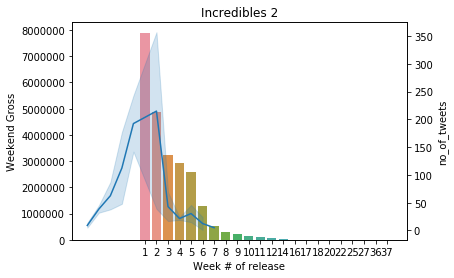

In [4]:
incredtwpivot = twpivot[twpivot['title'] =='Incredibles 2']
incredperf = perf[perf['Title'] =='Incredibles 2']

fig, ax = plt.subplots()
sns.barplot(x="Week # of release", y="Weekend Gross", data=incredperf, ax=ax).set_title("Incredibles 2")
ax2 = ax.twinx()
sns.lineplot('week_of_release', 'no_of_tweets', data=incredtwpivot, markers=True, dashes=False, ax=ax2)
fig.show()

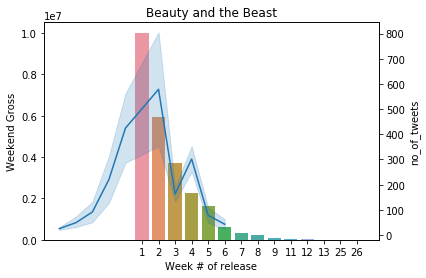

In [9]:
bbtwpivot = twpivot[twpivot['title'] =='beauty and the beast']
bbperf = perf[perf['Title'] =='Beauty and the Beast']

fig, ax = plt.subplots()
sns.barplot(x="Week # of release", y="Weekend Gross", data=bbperf, ax=ax).set_title('Beauty and the Beast')
ax2 = ax.twinx()
sns.lineplot('week_of_release', 'no_of_tweets', data=bbtwpivot, markers=True, dashes=False, ax=ax2)
fig.show()

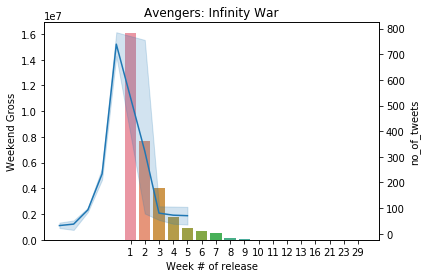

In [12]:
aventwpivot = twpivot[twpivot['title'] =='Avengers Infinity War']
avenperf = perf[perf['Title'] =='Avengers: Infinty War']

fig, ax = plt.subplots()
sns.barplot(x="Week # of release", y="Weekend Gross", data=avenperf, ax=ax).set_title('Avengers: Infinity War')
ax2 = ax.twinx()
sns.lineplot('week_of_release', 'no_of_tweets', data=aventwpivot, markers=True, dashes=False, ax=ax2)
fig.show()

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@user)
tweet['tidy_tweet'] = np.vectorize(remove_pattern)(tweet['post_content'], "@[\w]*")

# remove special characters, numbers, punctuations (except characters and hashtag with spaces)
tweet['tidy_tweet'] = tweet['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

tweet['tidy_tweet'].head(10)

0    After watching the new Beauty and the Beast it...
1    RT  Beauty and the Beast        Beauty and the...
2    does anyone know where i can watch beauty and ...
3    RT  Watch #BeautyAndTheBeast for evermore  The...
4     The live action director s cut of BEAUTY AND ...
5    Listen to me sing  Beauty and the Beast  on #S...
6    RT  #BeautyandtheBeast https   t co Lq fnoQYAP...
7    RT  beauty and the beast should never leave th...
8    RT  #BeautyandtheBeast https   t co Lq fnoQYAP...
9    I liked a  video https   t co dKhQjTUHjq Hones...
Name: tidy_tweet, dtype: object

In [4]:
#Removing short words
tweet['tidy_tweet'] = tweet['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Tokenization
tokenized_tweet = tweet['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [After, watching, Beauty, Beast, only, further...
1       [Beauty, Beast, Beauty, Beast, https, BeQRJmG]
2    [does, anyone, know, where, watch, beauty, bea...
3    [Watch, #BeautyAndTheBeast, evermore, live, ac...
4    [live, action, director, BEAUTY, BEAST, unnece...
Name: tidy_tweet, dtype: object

In [5]:
# stemming (pip install stemming==1.0)
from stemming.porter2 import stem


tokenized_tweet = tokenized_tweet.apply(lambda x: [stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [After, watch, Beauti, Beast, onli, further, c...
1       [Beauti, Beast, Beauti, Beast, https, BeQRJmG]
2    [doe, anyon, know, where, watch, beauti, beast...
3    [Watch, #BeautyAndTheBeast, evermor, live, act...
4    [live, action, director, BEAUTi, BEAST, unnece...
Name: tidy_tweet, dtype: object

In [6]:
#Stitch the tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

tweet['tidy_tweet'] = tokenized_tweet
tweet['tidy_tweet'].head(10)

0    After watch Beauti Beast onli further confirm ...
1              Beauti Beast Beauti Beast https BeQRJmG
2    doe anyon know where watch beauti beast onlin ...
3    Watch #BeautyAndTheBeast evermor live action a...
4        live action director BEAUTi BEAST unnecessari
5    Listen sing Beauti Beast #Smule https #SingKaraok
6    #BeautyandtheBeast https fnoQyAP https kCDw ht...
7                beauti beast should never leav cinema
8    #BeautyandtheBeast https fnoQyAP https kCDw ht...
9    like video https dKhQjTUHjq Honest Trailer Bea...
Name: tidy_tweet, dtype: object

In [7]:
# Create textblob objects of the tweets
tweet['sentiment'] = tweet['tidy_tweet'] .apply(lambda tweet: TextBlob(tweet).sentiment)

In [ ]:
# Create columns polarity and objectivity
tweet['polarity'], tweet['objectivity'] = tweet.sentiment.str[0], tweet.sentiment.str[1]
tweet = tweet.drop('sentiment', axis=1)
tweet.head()

In [20]:
#merge map with pivot
tweet1 = pd.merge(tweet, map, how='left', on=['title'])
tweet1['post_date_time'].dt.tz_localize(None)
tweet1['release day'].dt.tz_localize(None)

#Create day diff column
tweet1['day_diff'] = tweet1['release day'] - tweet1['post_date_time']
tweet1['day_diff'] = (pd.to_timedelta(tweet1.day_diff,unit='d')+pd.to_timedelta(1,unit='s')).astype('timedelta64[D]')

tweet1 = tweet1.assign(week_of_release=pd.cut(tweet1.day_diff,[-1000,-31,-22,-15,-8,-1,8,15,22,29,36,43,50,57,64,71,78,85, \
                                                                  92, 99, 106, 113, 120, 127, 134, 141, 148, 155, 162, 169, \
                                                                  176, 183, 190, 197, 204, 211, 218, 225, 232, 239, 246, 253, \
                                                                  1000], \
                                   labels = [-5,-4,-3,-2,-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12, \
                                             13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, \
                                             33, 34, 35, 36,
                                             37]))



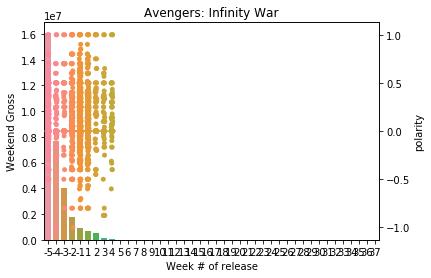

In [25]:
aventweet = tweet1[tweet1['title'] =='Avengers Infinity War']
avenperf = perf[perf['Title'] =='Avengers: Infinty War']

fig, ax = plt.subplots()
sns.barplot(x="Week # of release", y="Weekend Gross", data=avenperf, ax=ax).set_title('Avengers: Infinity War')
ax2 = ax.twinx()
sns.stripplot('week_of_release', 'polarity', data=aventweet, ax=ax2)
fig.show()

[(0, 9)]

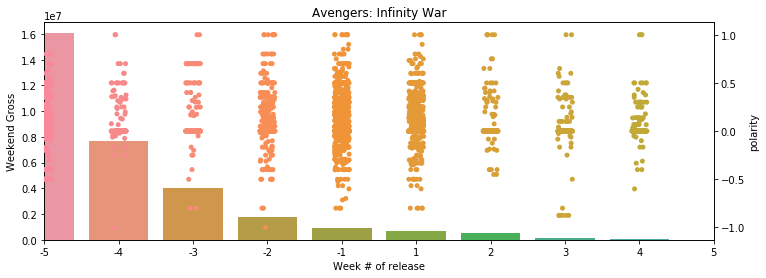

In [36]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x="Week # of release", y="Weekend Gross", data=avenperf, ax=ax).set_title('Avengers: Infinity War')
ax2 = ax.twinx()
sns.stripplot('week_of_release', 'polarity', data=aventweet, ax=ax2)
fig.show()

ax.set(xlim=(0, 9))

[(-5, 5)]

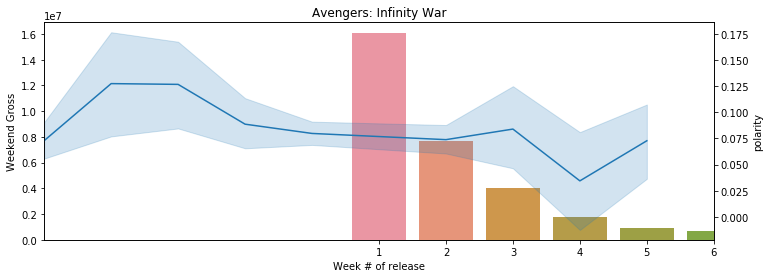

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x="Week # of release", y="Weekend Gross", data=avenperf, ax=ax).set_title('Avengers: Infinity War')
ax2 = ax.twinx()
sns.lineplot('week_of_release', 'polarity', data=aventweet, markers=True, dashes=False, ax=ax2)
fig.show()

ax.set(xlim=(-5, 5))

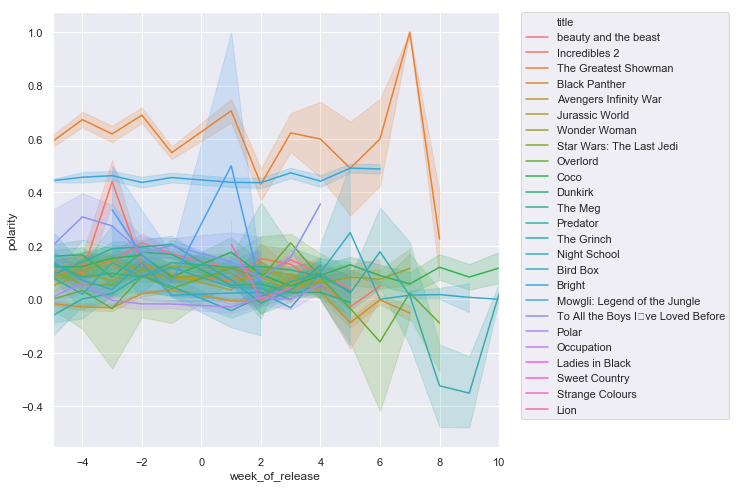

In [66]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})


sns.lineplot(x="week_of_release", y="polarity", hue="title", data=tweet1).set(xlim=(-5, 10))
#show legend out of chart
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

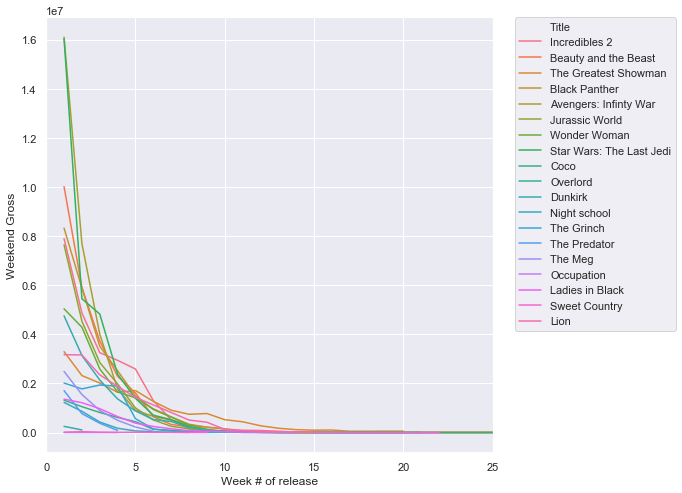

In [79]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})


sns.lineplot(x="Week # of release", y="Weekend Gross", hue="Title", data=perf).set(xlim=(0, 25))
#show legend out of chart
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

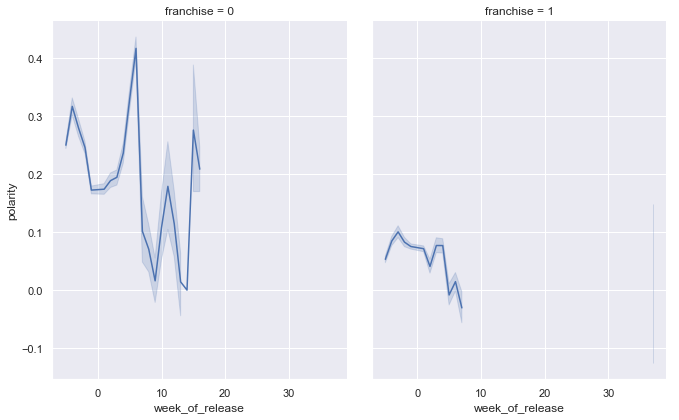

In [62]:
# Franchise or Not?
g = sns.FacetGrid(tweet1, col="franchise", height=6, aspect=.8)
g.map(sns.lineplot, "week_of_release", "polarity");

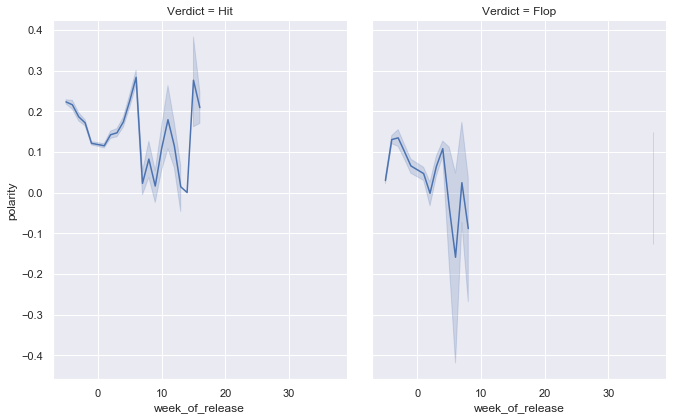

In [60]:
# Verdict: Hit or Flop? Sentiment Score
g = sns.FacetGrid(tweet1, col="Verdict", height=6, aspect=.8)
g.map(sns.lineplot, "week_of_release", "polarity");

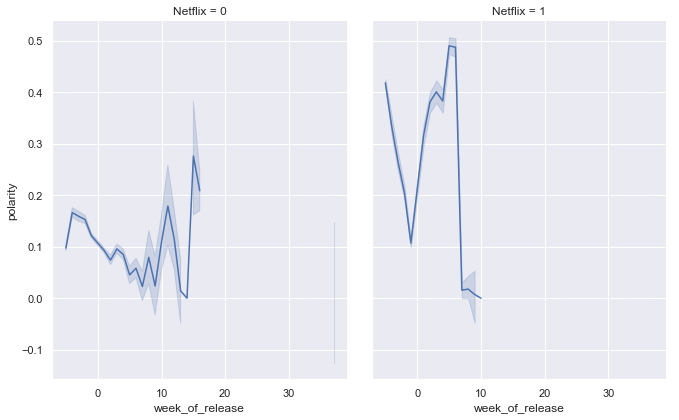

In [80]:
# Netflix movie?
g = sns.FacetGrid(tweet1, col="Netflix", height=6, aspect=.8)
g.map(sns.lineplot, "week_of_release", "polarity");

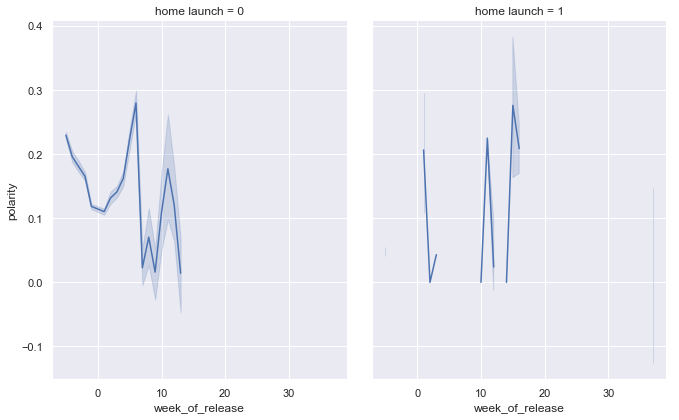

In [81]:
# Home launch?
g = sns.FacetGrid(tweet1, col="home launch", height=6, aspect=.8)
g.map(sns.lineplot, "week_of_release", "polarity");

No handles with labels found to put in legend.


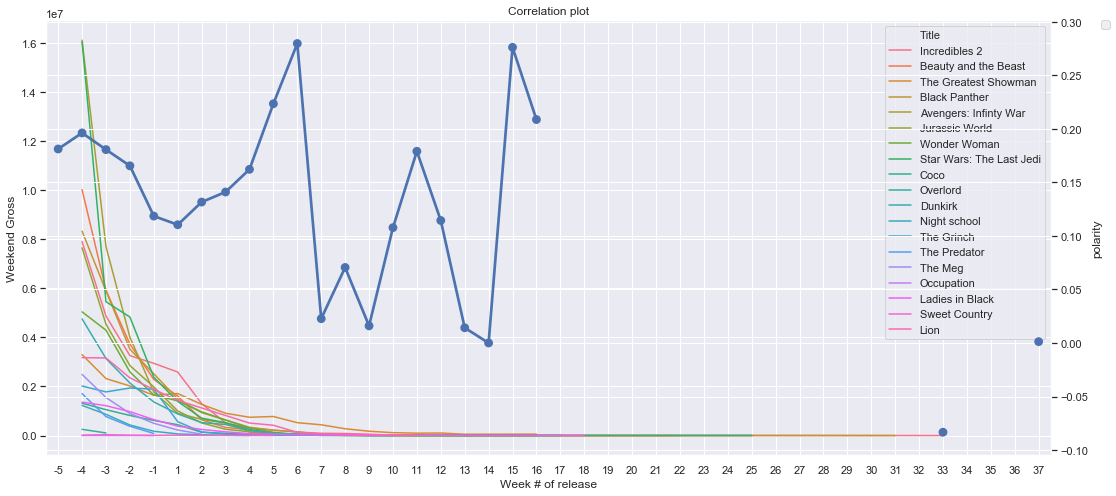

In [102]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x="Week # of release", y="Weekend Gross", hue="Title", data=perf).set_title('Correlation plot')
ax2 = ax.twinx()
sns.pointplot('week_of_release', 'polarity', data=tweet1, ci = None, ax=ax2)
fig.show()


#show legend out of chart
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)